In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torch.optim import AdamW

from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MultiLabelBinarizer
from torch.nn.utils.rnn import pad_sequence

from collections import Counter
import time
import warnings

In [2]:
# Setting device to CPU, as GPU is not available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

Device is: cuda


I use cuda because the video card handles complex models much faster than cpu.

In [3]:
# Suppressing specific (useless) warnings from the transformers module 
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers')

# Data preprocessing

In [4]:
# Loading dataset
file_path = 'JobLevelData.csv'
df = pd.read_csv(file_path, delimiter=';')

# Checking the presence of labels in each column
columns_with_labels = ['Column 1', 'Column 2', 'Column 3', 'Column 4']
label_counts = df[columns_with_labels].notna().sum()

In [5]:
# Replacing NaN values in label columns with empty strings
df[columns_with_labels] = df[columns_with_labels].fillna('')

In [6]:
# Combining labels from all columns into a single list for each job title
df['labels'] = df[columns_with_labels].apply(lambda row: [label for label in row if label != ''], axis=1)

Why merge labels? So that each position can have one list of all the labels associated with it, which is important for the multi-label classification task.

Why is this necessary? This is necessary for the model to be properly trained to predict all related labels for each post.

The main goal is to predict labels for each post, not to predict which column the post itself is in.

In [7]:
# Calculate the lengths of the label list for each line
df['num_labels'] = df['labels'].apply(len)

# Let's check the distribution of label lengths
length_distribution = df['num_labels'].value_counts().sort_index()

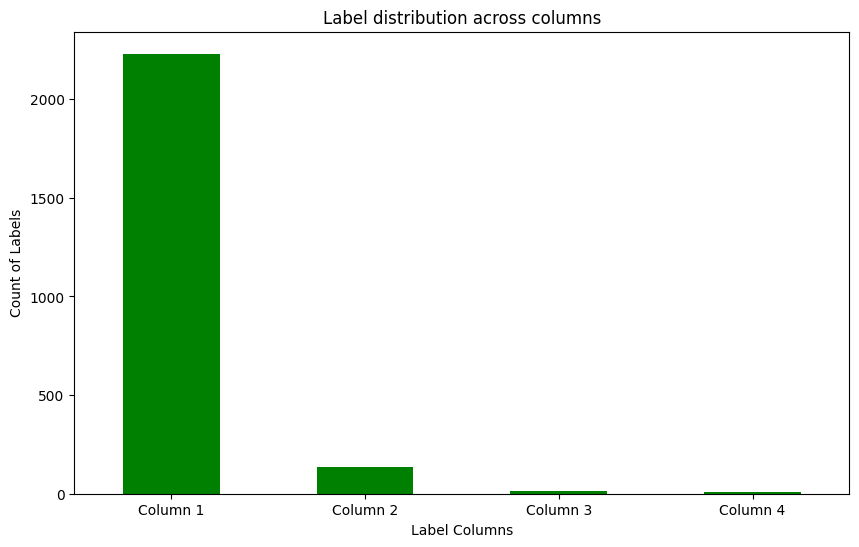

num_labels
0      10
1    2097
2     121
3       1
4      11
Name: count, dtype: int64

In [8]:
# Visualizing the distribution of labels across columns
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='green')
plt.title("Label distribution across columns")
plt.xlabel("Label Columns")
plt.ylabel("Count of Labels")
plt.xticks(rotation=0)
plt.show()

length_distribution

The largest number of labels is contained in Column 1, and the other columns contain fewer labels.

In [9]:
def plot_label_distribution(df, column_name='labels'):
    """
    Plots the distribution of labels in the specified column of a DataFrame.

    :param df: pandas DataFrame containing the data
    :param column_name: Name of the column that contains the labels (default is 'labels')
    :return: A pandas DataFrame with labels and their corresponding counts, sorted by frequency
    """
    # Collecting all labels into a single list
    all_label_occurrences = [label for sublist in df[column_name].values for label in sublist]

    # Counting occurrences of each label
    label_counts = Counter(all_label_occurrences)

    # Converting the label count data into a DataFrame for better visualization
    label_distribution = pd.DataFrame({
        'Label': list(label_counts.keys()),    
        'Count': list(label_counts.values())   
    })

    # Sorting the DataFrame by label frequency in descending order
    label_distribution = label_distribution.sort_values(by='Count', ascending=False)

    # Visualization of label distribution
    plt.figure(figsize=(10, 6))
    plt.barh(label_distribution['Label'], label_distribution['Count'], color='green')
    plt.xlabel('Quantity')
    plt.title('Label Distribution')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

    return label_distribution

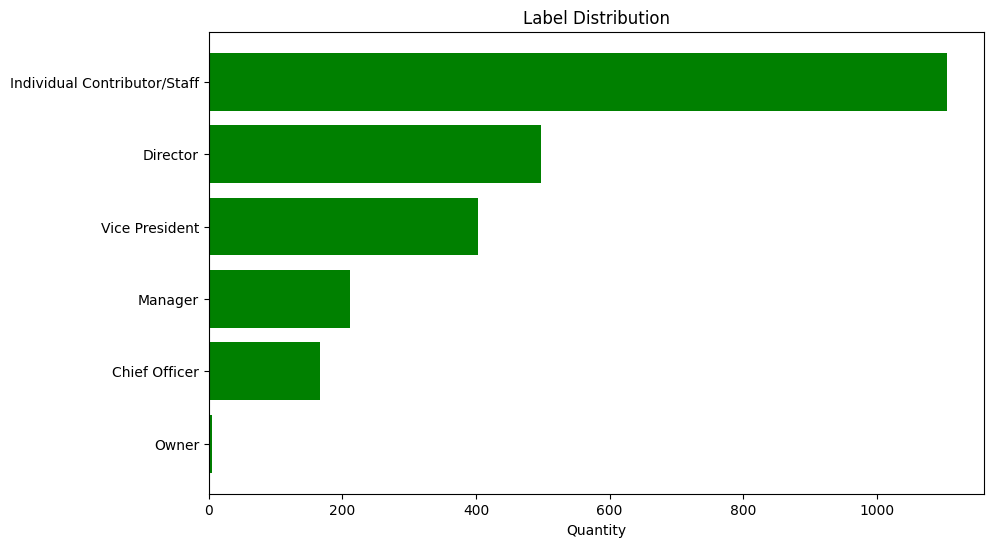

,Label,Count
2,Individual Contributor/Staff,1105
3,Director,497
0,Vice President,403
1,Manager,211
4,Chief Officer,166
5,Owner,4


In [10]:
plot_label_distribution(df)

An imbalance of labels (e.g., more “Individual Contributor/Staff” posts) may cause the model to be worse at recognizing less frequent labels.

It may be worth applying methods to correct it (e.g. oversampling/undersampling or using special losses for the model).

However, at this point it is worth saying that only label Owner can be problematic.

We will draw conclusions about the results later.

In [11]:
not_required_label = "Not Required"

# Count rows with empty labels before replacement
empty_labels_count = df['labels'].str.len().eq(0).sum()

# Replace empty label lists with "Not Required"
df['labels'] = df['labels'].apply(lambda labels: labels or [not_required_label])

# Count rows where labels were replaced with "Not Required"
not_required_count = df['labels'].apply(lambda labels: not_required_label in labels).sum()
print(f"Number of rows where labels were replaced with '{not_required_label}': {not_required_count}")

Number of rows where labels were replaced with 'Not Required': 10


In [12]:
# Collecting all unique labels from all columns, включая 'Not Required'
all_labels = list(sorted(set([label for sublist in df[columns_with_labels].values for label in sublist if label != ''])))

# Add 'Not Required' to the list of unique labels
if not_required_label not in all_labels:
    all_labels.append(not_required_label)

In [13]:
# Create a dictionary that assigns a unique index to each label
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}

In [14]:
# Convert labels to their respective indices
df['label_indices'] = df['labels'].apply(lambda labels: [label_to_idx[label] for label in labels])

In [15]:
# Filter rows where the 'labels' column contains 'Not Required'
not_required_rows = df[df['labels'].apply(lambda labels: "Not Required" in labels)]

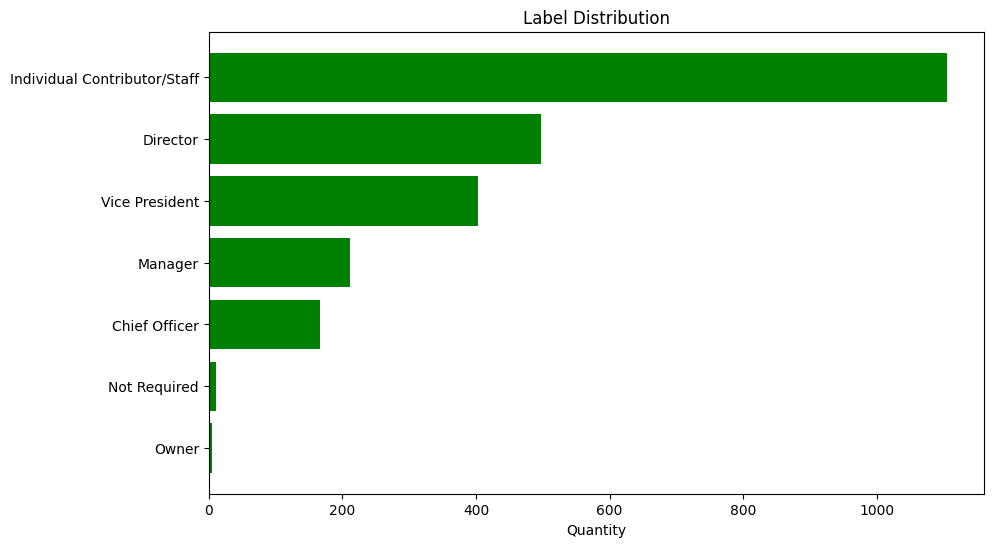

,Label,Count
2,Individual Contributor/Staff,1105
3,Director,497
0,Vice President,403
1,Manager,211
4,Chief Officer,166
6,Not Required,10
5,Owner,4


In [16]:
plot_label_distribution(df)

We see that the two poorly represented Labels take up 0.5% of the data.  We will use the function to calculate the weight of the weights relative to their frequency of occurrence. In this way we solve the problem of poorly represented data.

### Tokenize using distilBERT

Why distilBERT?

- Smaller size and higher efficiency: DistilBERT is a lightweight version of BERT (Bidirectional Encoder Representations from Transformers) that is trained using distillation, while preserving up to 97% of the quality of the original BERT. It is significantly lighter and faster in operation. Due to its bidirectional architectures, the model is good at capturing context and relationships between words in sentences.

- DistilBERT copes well with unstructured data such as job titles where different formats, styles and variations may be present. The model is capable of highlighting key features and dependencies in texts

- Thanks to its transformational architecture, DistilBERT can efficiently handle tasks where the same observation may belong to several classes (labels) at once

- DistilBERT provides an off-the-shelf tokenizer that efficiently partitions text into tokens, preserving the important information and structures needed for successful classification.

Bottom line:
- It combines efficiency and high quality text processing by utilizing an attention mechanism to understand context.
- It is lighter and faster compared to BERT, making it suitable for tasks requiring high performance without excessive resource consumption.
- Transformer-based models such as DistilBERT are better at processing text data by capturing both local and global dependencies in text, which is critical for complex text classification tasks.

In [17]:
# Tokenize job titles using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [18]:
# Each job title is tokenized and special tokens [CLS]-101 and [SEP]-102 are added
df['tokens'] = df['Title'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Data preparation for model

In [19]:
# Convert the labels into binary format
# Converts the list of label indices for each sample into a binary matrix
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(df['label_indices'])

# Convert the binary labels into PyTorch tensors
y_binary = torch.tensor(y_binary, dtype=torch.float32)

I originally planned to use embeddings to represent labels, as it allows for dense vector representations of categorical data and revealing relationships between labels. However, in a multi-label categorization task, embeddings are not suitable for simply representing multiple labels. As a result, I used the multi-label binary format.

In [20]:
# Define k-fold cross-validation
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

I decided to use Stratified K-Fold with shuffle because it gives a more robust estimation of the model compared to a simple split into train and test. In normal partitioning, labels may not be evenly distributed across samples, which is especially critical in the case of unbalanced data. Stratified K-Fold helps to maintain label proportions across all folds, which gives a more accurate picture of model performance. Shuffling the data before partitioning further prevents the influence of possible hidden patterns in the original order of the data.

In [21]:
def pad_token_sequences(token_lists, max_length=None):
    """
    Pads token sequences to ensure all sequences in a batch are of the same length.

    :param token_lists: A list of tokenized sequences (lists of token IDs) that need to be padded.
    :param max_length: Optional; the maximum length to pad or truncate the sequences to.
    :return: Tuple containing the padded token sequences and their corresponding attention masks.
    """
    # Convert the list of token sequences into PyTorch tensors
    token_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in token_lists]
    
    # Apply padding to ensure all sequences in the batch have the same length
    # pad_sequence ensures that shorter sequences are padded with the padding value (0 in this case)
    padded_tokens = pad_sequence(token_tensors, batch_first=True, padding_value=0)
    
    # If a max_length is provided, truncate the sequences to that length
    if max_length:
        padded_tokens = padded_tokens[:, :max_length]
    
    # Create an attention mask: 1 for real tokens, 0 for padding tokens
    attention_mask = (padded_tokens != 0).long()
    
    return padded_tokens, attention_mask

This “pad_token_sequences” function addresses the problem that the lengths of tokenized sequences can vary across data samples. Models such as BERT require that all sequences in a batch have the same length for proper processing.

An attention mask is created, where real tokens are labeled as 1 and padding tokens are labeled as 0. This helps the model to ignore padding during computation.

# Model Building

In [22]:
# Load a pre-trained BERT model for multi-label classification
# 1 is the number of unique labels in the dataset
num_labels = y_binary.shape[1]  

In [ ]:
# Load the pre-trained BERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

In [24]:
# Tokens from df
tokens = df['tokens'].values 

In [25]:
# Function to calculate class weights
def calculate_class_weights(y_binary):
    """
    Calculates class weights based on the inverse frequency of each class.
    This is useful for dealing with imbalanced datasets, where classes with fewer examples are given higher weights.
    """

    # Count the number of samples for each class by summing along the axis (columns) of the binary label matrix
    class_counts = y_binary.sum(axis=0).cpu().numpy()
    
    # Calculate the total number of samples in the dataset
    total_samples = len(y_binary)
    
    # Calculate class weights using square root of the inverse frequency of each class
    # Classes with fewer examples get higher weights
    class_weights = np.sqrt(total_samples / (len(class_counts) * class_counts))
    
    # Print the class weights for debugging purposes
    print("Class weights:", class_weights)

    # Return the class weights as a PyTorch tensor
    return torch.tensor(class_weights, dtype=torch.float32)

To balance the class imbalance, we assign higher weights to classes with fewer examples, encouraging the model to pay more attention to these rare classes during training.

In [ ]:
# Define the loss function and optimizer

class_weights = calculate_class_weights(y_binary).to(device)

# It combines a sigmoid activation with binary cross-entropy loss, which is ideal for predicting multiple labels.
# Initialization of the loss function taking into account class weights
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

# AdamW helps in controlling weight decay during optimization, which is especially useful for models like BERT.
optimizer = AdamW(model.parameters(), lr=2e-5)  

 The BCEWithLogitsLoss function was chosen because it combines sigmoid activation and binary cross-entropy in one step, which is particularly suitable for multi-label classification tasks. In such tasks, each class is predicted independently, and the sigmoid helps transform the model logits into probabilities for each class. This allows us to efficiently handle the binary labels (0 or 1) for each class and consider them simultaneously.

The AdamW optimizer was chosen because it effectively handles the optimization task by controlling weight decay, which controls the updating of the model weights, preventing them from increasing too much during training. Weight decay adds regularization, which reduces the likelihood of overfitting.

### Main training loop

In [ ]:
print(f"Using device: {device}")

# Specify number of epochs and batch size
num_epochs = 3
batch_size = 4

# Iterating through each fold of cross-validation
for fold, (train_index, test_index) in enumerate(mskf.split(df['tokens'], y_binary)):
    print(f"\nFold {fold + 1}")

    # Start timer for the fold
    fold_start_time = time.time()

    # Splitting data into training and test sets for the current fold
    X_train, X_test = df['tokens'].iloc[train_index], df['tokens'].iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]  # Already in tensor format

    # Convert training and test data to list form for padding
    X_train = list(X_train)
    X_test = list(X_test)

    # Apply padding and create attention masks for training and test sets
    X_train_padded, X_train_mask = pad_token_sequences(X_train, max_length=128)
    X_test_padded, X_test_mask = pad_token_sequences(X_test, max_length=128)

    # Move the data to the specified device (CPU or GPU)
    X_train_padded = X_train_padded.to(device)
    X_train_mask = X_train_mask.to(device)
    y_train = y_train.to(device)

    X_test_padded = X_test_padded.to(device)
    X_test_mask = X_test_mask.to(device)
    y_test = y_test.to(device)

    # Move the model to the specified device
    model.to(device)

    # Create a DataLoader for batching the training data
    train_dataset = TensorDataset(X_train_padded, X_train_mask, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Loop through each epoch
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start time for the epoch

        model.train()  # Set the model to training mode
        total_loss = 0  # Initialize the total loss for the epoch

        # Loop through each batch in the DataLoader
        for batch in train_loader:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass through the model
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)

            # Calculate the loss using the criterion (BCEWithLogitsLoss)
            loss = criterion(outputs.logits, batch_labels)

            # Backpropagation and optimization step
            optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights

            # Accumulate loss
            total_loss += loss.item()

        # Calculate time taken for the epoch
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(train_loader)}, Epoch Time: {epoch_time:.2f} sec\n")

        # Evaluate on the training set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            # Predictions on the training set
            outputs_train = model(input_ids=X_train_padded, attention_mask=X_train_mask)
            train_predictions = torch.sigmoid(outputs_train.logits) > 0.5  # Convert logits to binary predictions

            # Compute metrics on training set
            train_f1 = f1_score(y_train.cpu(), train_predictions.cpu(), average='micro')
            train_accuracy = accuracy_score(y_train.cpu(), train_predictions.cpu())

            # Predictions on the test set
            outputs_test = model(input_ids=X_test_padded, attention_mask=X_test_mask)
            test_predictions = torch.sigmoid(outputs_test.logits) > 0.5  # Convert logits to binary predictions

            # Compute metrics on test set
            test_f1 = f1_score(y_test.cpu(), test_predictions.cpu(), average='micro')
            test_accuracy = accuracy_score(y_test.cpu(), test_predictions.cpu())

            # Print training and test metrics for the current epoch
            print(f"F1-score on TRAIN set (epoch {epoch+1}): {train_f1}")
            print(f"Accuracy on TRAIN set (epoch {epoch+1}): {train_accuracy}")

            print(f"\nF1-score on TEST set (epoch {epoch+1}): {test_f1}")
            print(f"Accuracy on TEST set (epoch {epoch+1}): {test_accuracy}")

    # Final evaluation on the test set after all epochs for the current fold
    model.eval()
    with torch.no_grad():
        # Final predictions on the test set for the current fold
        outputs_test = model(input_ids=X_test_padded, attention_mask=X_test_mask)
        test_predictions = torch.sigmoid(outputs_test.logits) > 0.5  # Convert logits to binary predictions

        # Compute final metrics on the test set
        test_f1 = f1_score(y_test.cpu(), test_predictions.cpu(), average='micro')
        test_accuracy = accuracy_score(y_test.cpu(), test_predictions.cpu())

        # Print final metrics for the fold
        print(f"\nF1-score on TEST set (fold {fold+1}): {test_f1}")
        print(f"Accuracy on TEST set (fold {fold+1}): {test_accuracy}\n")

    # Print the total time taken for the fold
    fold_time = time.time() - fold_start_time
    print(f"Fold {fold+1} completed in: {fold_time:.2f} sec")


Example of last output from previous cell: 
F1 on TEST set (fold 5): 0.994 | 
Accuracy on TEST set (fold 5): 0.992

I chose F1-score and Accuracy metrics to evaluate model performance because they complement each other. F1-score is particularly important in tasks with unbalanced classes because it considers both precision and recall, which allows for a more accurate assessment of how well the model predicts rare labels.
 
Accuracy, on the other hand, gives a general idea of the proportion of correctly predicted examples and is easy to interpret.

In [ ]:
# Path to model
output_dir = 'distilBERT_model_new'

In [ ]:
# Save the model's weights and configuration
# This saves not only the model's parameters but also its configuration (e.g., architecture type, number of layers)
model.save_pretrained(output_dir)

# Save the tokenizer used during training
# Saving the tokenizer ensures that when the model is later loaded, it uses the same tokenization process (e.g., special tokens, vocabulary) for consistent preprocessing
tokenizer.save_pretrained(output_dir)

# GENERATE FROM MODEL SAVE

In [ ]:
# Set the device for prediction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Using CPU here; switch to "cuda" if you have access to a GPU
print(f"Using device: {device}")

# Load the saved model and tokenizer from the directory where they were saved
model = DistilBertForSequenceClassification.from_pretrained(output_dir).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(output_dir)

# Send the model to the device (in this case, CPU)
model.to(device)

new_texts = df['Title']

# Dictionary to store predicted labels for each text
predicted_labels_dict = {}

# Loop over each text in the list for prediction
for text in new_texts:
    # Tokenize the new text
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  
        max_length=128,  
        padding='max_length', 
        return_tensors='pt' 
    )

    # Extract input_ids and attention_mask from tokenized input
    input_ids = inputs['input_ids'].to(device) 
    attention_mask = inputs['attention_mask'].to(device) 

    model.eval()

    with torch.no_grad():
        # Pass the input through the model to get the logits 
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  

    probs = torch.sigmoid(logits)

    # # Logits and probabilities for debugging or inspection
    # print(f"Logits: {logits}")
    # print(f"Probabilities: {probs}")

    # Apply a threshold (0.5) to determine the final predictions 
    predictions = (probs > 0.5).cpu().numpy()  # Convert to NumPy and apply threshold

    predicted_label_indices = [i for i, val in enumerate(predictions[0]) if val == 1]

    # Use `all_labels` to map indices to their corresponding label names
    predicted_labels = [all_labels[i] for i in predicted_label_indices]

    predicted_labels_dict[text] = predicted_labels

    print(f"Predicted labels for '{text}': {predicted_labels}")

In [ ]:
# Checking predictions by comparing them with real labels from the dataset

counter = 0
dubious_predictions = []

for text in new_texts:
   
    real_labels = df[df['Title'] == text]['labels'].values

    if len(real_labels) > 0:
        real_labels = real_labels[0]  
        print(f"Real labels for '{text}': {real_labels}")
    else:

        print(f"Real labels for '{text}' not found in the dataset.")

    predicted_labels = predicted_labels_dict.get(text, [])
    
    if set(predicted_labels) == set(real_labels):
        print(f"Prediction for '{text}' is correct.")
    else:
        counter += 1
        wrong = f"Prediction error for '{text}'. Predicted: {predicted_labels}, Expected: {real_labels} WRONG"
        dubious_predictions.append(wrong)
        print(wrong)
    print("\n")
print(f"Wrong predictions {counter} out of {len(new_texts)}")

In [ ]:
# for sentence in dubious_predictions:
#     print(f"{sentence}\n\n")
print(f"Wrong predictions {len(dubious_predictions)} out of {len(new_texts)}")